In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt

import tifffile

In [2]:
data_path = 'data/single_cell_data_with_mask'
# checkpoint_path = 'checkpoints/ResVAE-latentdim128-bg0.5/2023-08-01_16-13-45/VAE_Epoch_500_Loss_10178044305408.0.pth'
# checkpoint_path = 'checkpoints/ResVAE-latentdim128/2023-07-31_14-07-03/VAE_Epoch_500_Loss_10726362560512.0.pth'
# checkpoint_path = 'checkpoints/ResVAE-latentdim128-bg0.5-sigma0.01/2023-08-02_12-59-26/VAE_Epoch_500_Loss_10452021455872.0.pth'
checkpoint_path = 'checkpoints/Fixed20_Res_VAE-sigma_0.001-latentdim128/2023-07-20_16-03-59/VAE_Epoch_500_Loss_13549153273856.0.pth'

output_path = 'output/ResVAE-latentdim128-bg0.5/2023-08-01_16-13-45'

if not os.path.exists(output_path):
    os.makedirs(output_path)

mean = np.array([6076.685883679818, 1350.9691095158794, 5090.145564947434, 5019.978020658786])
std = np.array([5504.395544161098, 1145.6356702621574, 663.3312283427825, 706.0040270727409])

batch_size = 128

seed = 42

latent_dim = 128
layer_list = [2, 2, 2, 2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std), transforms.Resize((32, 32))])
trans_mask = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])

class CellDataset(Dataset):
    def __init__(self, data_path, transform=None, transform_mask=None):
        self.transform = transform
        self.transform_mask = transform_mask
        self.data_path = data_path
        self.data = os.listdir(data_path)
        self.data = [i for i in self.data if not i.endswith('_mask.tif')]
        self.data.sort()
        self.data = [os.path.join(data_path, i) for i in self.data]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = tifffile.imread(self.data[idx])
        img = img.astype(np.float32)
        # print(img[0][0])
        img = np.transpose(img, (1, 2, 0))
        mask = tifffile.imread(self.data[idx][:-4] + '_mask.tif')
        # print(mask)
        if self.transform:
            img = self.transform(img)
            mask = self.transform_mask(mask)
        return img, mask

# create dataset and dataloader
dataset = CellDataset(data_path, transform=trans, transform_mask=trans_mask)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [3]:
# define VAE model
import math
def calc_activation_shape(dim, ksize=(5, 5), stride=(1, 1), padding=(0, 0), dilation=(1, 1), output_padding=(0, 0),
                          transposed=False):
    def shape_each_dim(i):
        if transposed:
            odim_i = (dim[i] - 1) * stride[i] - 2 * padding[i] + dilation[i] * (ksize[i] - 1) + 1 + output_padding[i]
        else:
            odim_i = dim[i] + 2 * padding[i] - dilation[i] * (ksize[i] - 1) - 1
            odim_i = odim_i / stride[i] + 1
        return math.floor(odim_i)

    return shape_each_dim(0), shape_each_dim(1)



class EncoderBottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, ln_shape, use_batch_norm=True, stride=1, downsample=None):
        super(EncoderBottleneckBlock, self).__init__()
        ln_shape = calc_activation_shape(ln_shape, ksize=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.norm_1 = nn.BatchNorm2d(planes) if use_batch_norm else nn.LayerNorm([planes, *ln_shape])

        ln_shape = calc_activation_shape(ln_shape, ksize=(5, 5), stride=(stride, stride), padding=(2, 2))
        self.conv_2 = nn.Conv2d(planes, planes, kernel_size=5, stride=stride, padding=2, bias=False)
        self.norm_2 = nn.BatchNorm2d(planes) if use_batch_norm else nn.LayerNorm([planes, *ln_shape])

        ln_shape = calc_activation_shape(ln_shape, ksize=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.norm_3 = nn.BatchNorm2d(planes * self.expansion) if use_batch_norm else nn.LayerNorm([planes * self.expansion, *ln_shape])

        self.relu = nn.LeakyReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv_1(x)

        out = self.norm_1(out)
        out = self.relu(out)

        out = self.conv_2(out)
        out = self.norm_2(out)
        out = self.relu(out)

        out = self.conv_3(out)
        out = self.norm_3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Encoder(nn.Module):

    def __init__(self, latent_dim, use_batch_norm, dropout, layers):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.use_batch_norm = use_batch_norm
        self.dropout = dropout
        self.layers = layers

        self.ln_shape = (32, 32)

        self.conv_1 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1, bias=False)
        self.inplanes = 8

        self.ln_shape = calc_activation_shape(self.ln_shape, ksize=(3, 3), stride=(2, 2), padding=(1, 1))
        self.norm_layer_1 = nn.BatchNorm2d(8) if use_batch_norm else nn.LayerNorm([8, *self.ln_shape])
        self.relu = nn.LeakyReLU(inplace=True)

        self.layer_1 = self._make_layer(8, layers[0], stride=2)
        self.layer_2 = self._make_layer(8, layers[1], stride=2)
        self.layer_3 = self._make_layer(16, layers[2], stride=2)
        self.layer_4 = self._make_layer(32, layers[3])

        self.conv_1x1 = nn.Sequential(nn.Conv2d(128, 16, kernel_size=1),
                                      nn.BatchNorm2d(16) if use_batch_norm else nn.LayerNorm([16, *self.ln_shape]),
                                      nn.LeakyReLU(inplace=True))

        linear_dim = 16 * self.ln_shape[0] * self.ln_shape[1]
        self.fc_mu = nn.Linear(linear_dim, latent_dim)
        self.fc_var = nn.Linear(linear_dim, latent_dim)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        ln_shape = calc_activation_shape(self.ln_shape, ksize=(5, 5), stride=(stride, stride), padding=(2, 2))
        if stride != 1 or self.inplanes != planes * EncoderBottleneckBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * EncoderBottleneckBlock.expansion,
                          kernel_size=5, padding=2, stride=stride, bias=False),
                nn.BatchNorm2d(planes * EncoderBottleneckBlock.expansion) if self.use_batch_norm else nn.LayerNorm([planes * EncoderBottleneckBlock.expansion, *ln_shape]),
            )

        layers = [EncoderBottleneckBlock(self.inplanes, planes, self.ln_shape, self.use_batch_norm, stride, downsample)]

        self.inplanes = planes * EncoderBottleneckBlock.expansion

        for i in range(1, blocks):
            layers.append(EncoderBottleneckBlock(self.inplanes, planes, ln_shape, self.use_batch_norm))

        self.ln_shape = ln_shape

        return nn.Sequential(*layers)

    def encode(self, x):
        """
        Pass the input to the encoder and get the latent distribution
        :param x: input of shape (B, C, H, W)
        :return: vectors mu and log_var produced by the encoder
        """
        # Compute encoder output
        x = self.conv_1(x)
        x = self.norm_layer_1(x)
        x = self.relu(x)

        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.conv_1x1(x)
        # print(x.shape)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)

        return mu, log_var

    def forward(self, x):
        """
        Get the latent encoding of the data_loaders and sample z from a learned distribution
        :param x: input of shape (B, C, H, W)
        :return: sample from the distribution q_zx,
                 a list containing mu and sigma vectors
        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)

        return [z, mu, log_var]

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick
        :param mu: vector of means produced by the encoder
        :param log_var: vector of log variances produced by the encoder
        :return: sample from the distribution parametrized by mu and var
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + std * eps


class DecoderBottleneckBlock(nn.Module):
    expansion = 4  # expansion factor

    def __init__(self, in_channels, planes, ln_shape, use_batch_norm=False, upsample=None, stride=2, output_padding=0):
        super(DecoderBottleneckBlock, self).__init__()

        self.upsample = upsample
        self.stride = stride
        self.use_batch_norm = use_batch_norm

        ln_shape = calc_activation_shape(ln_shape, ksize=(1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1), output_padding=(0, 0), transposed=True)
        self.conv_1 = nn.ConvTranspose2d(in_channels, planes, kernel_size=1, stride=1, padding=0)
        self.norm_1 = nn.BatchNorm2d(planes) if self.use_batch_norm else nn.LayerNorm([planes, *ln_shape])

        ln_shape = calc_activation_shape(ln_shape, ksize=(5, 5), stride=(stride, stride), padding=(2, 2), dilation=(1, 1), output_padding=(output_padding, output_padding), transposed=True)
        self.conv_2 = nn.ConvTranspose2d(planes, planes, kernel_size=5, stride=self.stride, padding=2, output_padding=output_padding)
        self.norm_2 = nn.BatchNorm2d(planes) if self.use_batch_norm else nn.LayerNorm([planes, *ln_shape])

        ln_shape = calc_activation_shape(ln_shape, ksize=(1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1), output_padding=(0, 0), transposed=True)
        self.conv_3 = nn.ConvTranspose2d(planes, planes * self.expansion, kernel_size=1, stride=1, padding=0)
        self.norm_3 = nn.BatchNorm2d(planes * self.expansion) if self.use_batch_norm else nn.LayerNorm([planes * self.expansion, *ln_shape])

        self.relu = nn.LeakyReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.norm_1(self.conv_1(x)))
        x = self.relu(self.norm_2(self.conv_2(x)))
        x = self.relu(self.norm_3(self.conv_3(x)))

        if self.upsample is not None:
            identity = self.upsample(identity)

        x = x + identity
        x = self.relu(x)

        return x


class Decoder(nn.Module):

    def __init__(self, latent_dim, use_batch_norm, dropout, layers=[1, 1, 1, 1]):
        """
        :param latent_dim: size of the latent space
        """
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.use_batch_norm = use_batch_norm
        self.dropout = dropout
        self.layers = layers
        # self.ln_shape = (8, 8)
        self.ln_shape = (2, 2)

        self.in_channels = 16
        linear_dim = self.in_channels * self.ln_shape[0] * self.ln_shape[1]
        self.dense_1 = nn.Linear(latent_dim, linear_dim)

        # Build the residual decoder
        self.layer_1 = self._make_layer(layers[3], planes=32)
        self.layer_2 = self._make_layer(layers[2], planes=32, stride=2, output_padding=1)
        self.layer_3 = self._make_layer(layers[1], planes=16, stride=2, output_padding=1)
        self.layer_4 = self._make_layer(layers[0], planes=8, stride=2, output_padding=1)
        self.layer_5 = self._make_layer(1, planes=8, stride=2, output_padding=1)

        self.upconv_1 = nn.Conv2d(32, 4, kernel_size=3, stride=1, padding=1)

    def _make_layer(self, stack, planes, stride=1, output_padding=0):
        sub_layers = []
        upsample = None

        # Initialize upsampling
        ln_shape = calc_activation_shape(self.ln_shape, ksize=(1, 1), stride=(stride, stride), padding=(0, 0), dilation=(1, 1), output_padding=(output_padding, output_padding), transposed=True)
        upsample = nn.Sequential(
            nn.ConvTranspose2d(self.in_channels, planes * DecoderBottleneckBlock.expansion, kernel_size=1,
                               stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(planes * DecoderBottleneckBlock.expansion) if self.use_batch_norm else nn.LayerNorm([planes * DecoderBottleneckBlock.expansion, *ln_shape])
        )

        # First stack layer
        sub_layers.append(DecoderBottleneckBlock(self.in_channels, planes, self.ln_shape, use_batch_norm=self.use_batch_norm, upsample=upsample, stride=stride,
                                                 output_padding=output_padding))
        self.in_channels = planes * DecoderBottleneckBlock.expansion

        # Other stack layers
        for i in range(stack - 1):
            sub_layers.append(DecoderBottleneckBlock(self.in_channels, planes, ln_shape, use_batch_norm=self.use_batch_norm, upsample=None, stride=1))

        self.ln_shape = ln_shape

        return nn.Sequential(*sub_layers)

    def forward(self, z):
        """
        Reconstruct the image from the latent code
        :param z: sample from the latent distribution
        :return: reconstruction of the sample z
        """
        x = self.dense_1(z)
        x = x.reshape(-1, 16, 2, 2)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x_hat = self.upconv_1(x)

        # return torch.sigmoid(x_hat)
        return x_hat


class ResVAE(nn.Module):

    def __init__(self, latent_dim, use_batch_norm=False, dropout=0.0, layer_list=None):
        super(ResVAE, self).__init__()

        if layer_list is None:
            layer_list = [3, 4, 6, 3]

        self.encoder = Encoder(latent_dim, use_batch_norm, dropout, layer_list)
        self.decoder = Decoder(latent_dim, use_batch_norm, dropout, layer_list)
        self.latent_dim = latent_dim

    def encode(self, x):
        z, _, _ = self.encoder(x)
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def sample(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(device)
        return z

In [4]:
model = ResVAE(latent_dim=latent_dim, use_batch_norm=True, dropout=0.0, layer_list=layer_list)
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)

ResVAE(
  (encoder): Encoder(
    (conv_1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm_layer_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (layer_1): Sequential(
      (0): EncoderBottleneckBlock(
        (conv_1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_2): Conv2d(8, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (norm_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        (downsample): Sequential(
          (0): Conv2d(8,

In [5]:
# original = []
# recon = []

model.eval()
for i, (data, mask) in enumerate(dataloader): 
    data, mask = data.to(device), mask.to(device)
    recon, mu, logvar = model(data)
    if i == 0:
        original = data.cpu().detach()
        recononstruction = recon.cpu().detach()
        z = mu.cpu().detach()
        # labels = torch.zeros(batch_size)
        break
    # else:
    #     original = torch.cat((original, data.cpu().detach()), 0)
    #     recononstruction = torch.cat((recononstruction, recon.cpu().detach()), 0)
    #     z = torch.cat((z, mu.cpu().detach()), 0)
        # labels = torch.cat((labels, torch.zeros(batch_size) + i), 0)

# empty cache
torch.cuda.empty_cache()

original = original.numpy()
recononstruction = recononstruction.numpy()
z = z.numpy()
# labels = labels.cpu().detach().numpy()

c:\Users\hx57\AppData\Local\anaconda3\envs\jra\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(128, 128)
(128, 2)


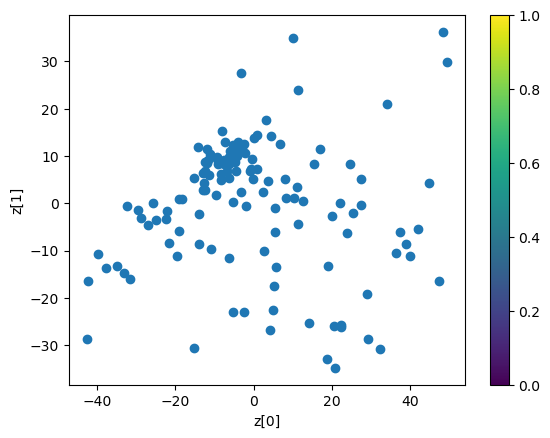

In [6]:
# visualize latent dim
print(z.shape)

# do PCA on latent dim
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(z)
z_pca = pca.transform(z)
print(z_pca.shape)

plt.figure()
plt.scatter(z_pca[:, 0], z_pca[:, 1])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [14]:
print(original.shape, recononstruction.shape, std.shape, mean.shape)

original = original.transpose(0, 2, 3, 1) * std + mean
recononstruction = recononstruction.transpose(0, 2, 3, 1) * std + mean

original = original.transpose(0, 3, 1, 2)
recononstruction = recononstruction.transpose(0, 3, 1, 2)

# for i in range(len(original)): 
#     for j in range(4):
#         original[i][j] = original[i][j] * std[j] + mean[j]
#         recononstruction[i][j] = recononstruction[i][j] * std[j] + mean[j]

(128, 4, 32, 32) (128, 4, 32, 32) (4,) (4,)


In [15]:
original.shape, original.dtype, recononstruction.shape, recononstruction.dtype

((128, 4, 32, 32), dtype('float64'), (128, 4, 32, 32), dtype('float64'))

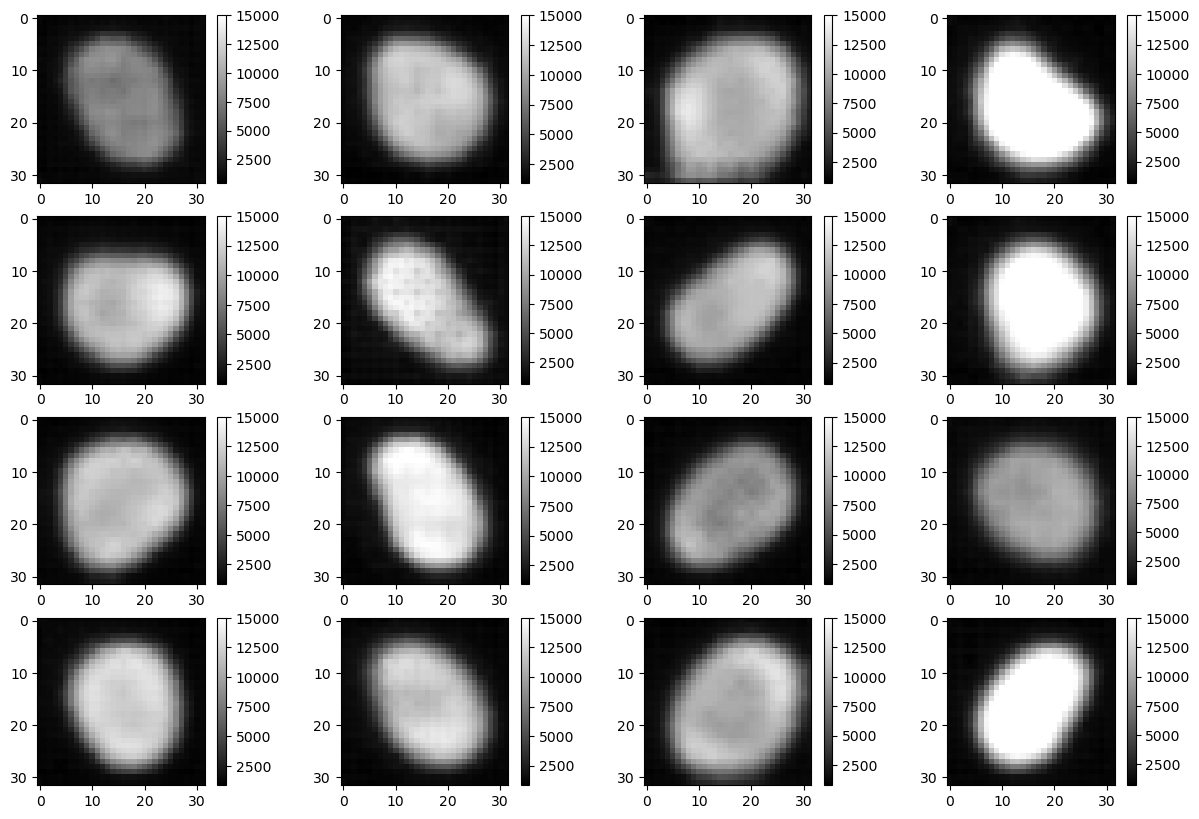

In [35]:
# visualize reconstruction images
plt.figure(figsize=(15, 10))
# plt.suptitle('Reconstruction Images', fontsize=20)
for i in range(16): 
    plt.subplot(4, 4, i+1)
    plt.imshow(recononstruction[i][0], cmap='gray', vmax=15000, vmin=2000)
    plt.colorbar()

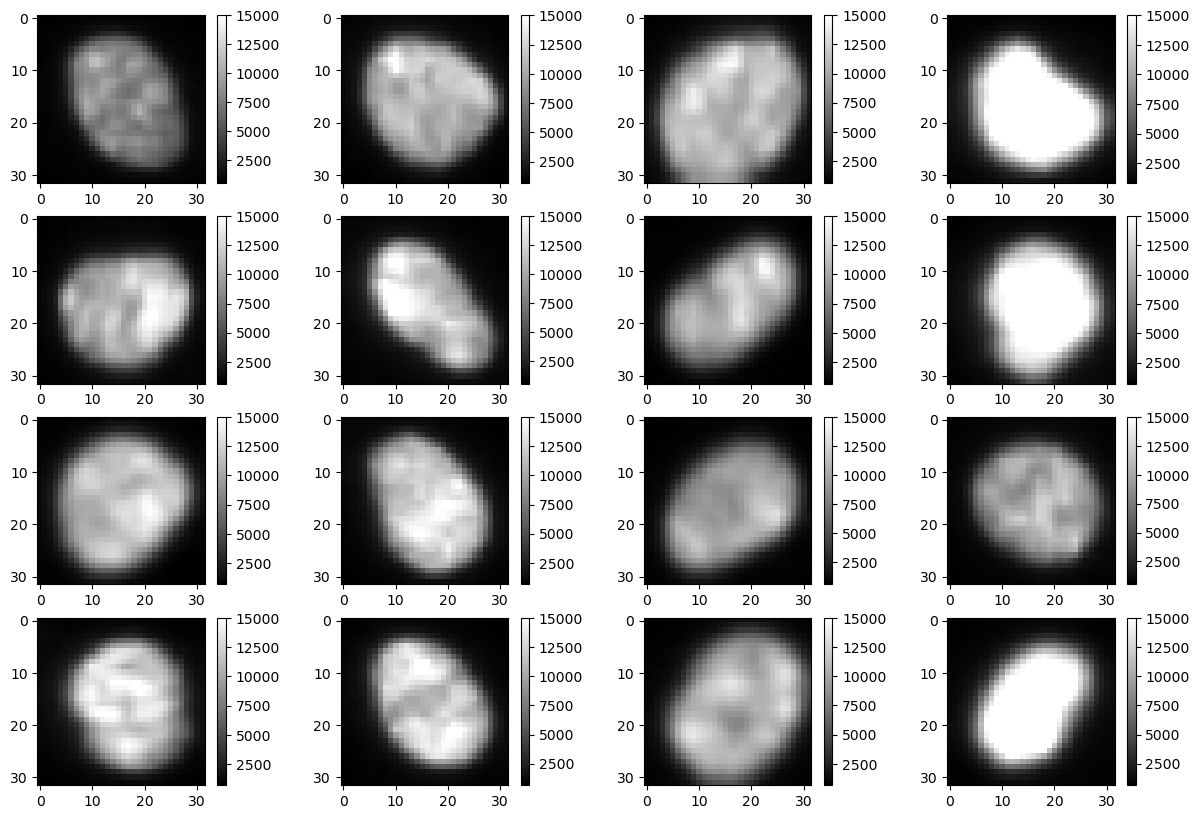

: 

In [36]:
# visualize original images
plt.figure(figsize=(15, 10))
# plt.suptitle('Original Images', fontsize=20)
for i in range(16): 
    plt.subplot(4, 4, i+1)
    plt.imshow(original[i][0], cmap='gray', vmax=15000, vmin=2000)
    plt.colorbar()

In [1]:
import logging
import os
import time

log_dir = 'lo/' + time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.addHandler(logging.FileHandler(os.path.join(log_dir, 'log.txt')))

In [2]:
print(logger.handlers)

[<FileHandler c:\Users\hx57\Desktop\JRA\lo\2023-08-07-15-41-46\log.txt (NOTSET)>]


In [3]:
print(logger.handlers[0].baseFilename)

c:\Users\hx57\Desktop\JRA\lo\2023-08-07-15-41-46\log.txt


In [5]:
#get the dir of the log file
log_path = logger.handlers[0].baseFilename
log_dir = os.path.dirname(log_path)

In [6]:
print(log_dir)

c:\Users\hx57\Desktop\JRA\lo\2023-08-07-15-41-46
